# CNN Model

- input = image

- output = score (Mean Vol After Open / Mean Vol Before Open) 

### 0. Installation (torch & fastai)

In [1]:
import torch

In [2]:
# make sure torch version is compatible with cuda 10.1
torch.__version__

'1.7.1+cu101'

In [3]:
# make sure fastai version is 1
pip show fastai

Name: fastai
Version: 1.0.61
Summary: fastai makes deep learning with PyTorch faster, more accurate, and easier
Home-page: https://github.com/fastai/fastai
Author: Jeremy Howard
Author-email: info@fast.ai
License: Apache Software License 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: Pillow, pandas, requests, nvidia-ml-py3, pyyaml, numexpr, torchvision, scipy, matplotlib, fastprogress, packaging, spacy, beautifulsoup4, bottleneck, numpy, torch
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [5]:
from fastai.imports import * 
from fastai.vision import * 
from fastai.metrics import error_rate

In [6]:
torch.cuda.empty_cache()

In [7]:
print(torch.version.cuda)

10.1


In [8]:
torch.cuda.is_available()

True

In [9]:
torch.cuda.set_device(0)

### 1. Data Prep

In [20]:
path = '../data/imgs/all'
df = pd.read_csv(path+'/image_label_dir.csv', header='infer')
df.head()

,image_id,label
0,2019-01-30.png,8
1,2019-01-31.png,3
2,2019-02-01.png,8
3,2019-02-04.png,5
4,2019-02-05.png,9


In [21]:
data = ImageDataBunch.from_df(path, df, valid_pct=0.2, seed=10, size=224)
#data = (ImageDataBunch.from_csv('../data/imgs/all', 'image_label_dir.csv',  size=224, bs = 5, num_workers = 0)) #valid_pct=0.2, seed=10,
#         .random_split_by_pct(valid_pct=0.2, seed=10))
#         .split_by_idxs(list(range(400)), list(range(400,496))))
#                  .label_from_df()
#                  .databunch())

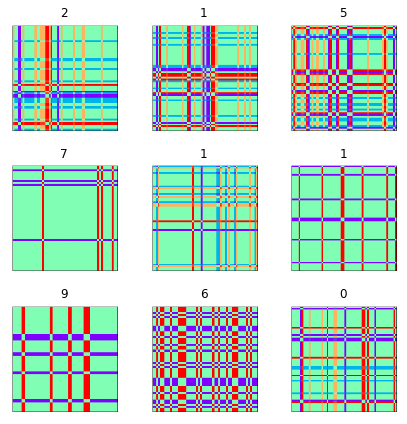

In [23]:
data.show_batch(rows=3, figsize=(6,6))

### 2. cnn model

In [24]:
# Create custom_head
layers = [AdaptiveConcatPool2d(), Flatten(), nn.Linear(1024,10)]
head = nn.Sequential(*layers)

In [25]:
learner = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy]).to_fp16() # pretrianed = True, custom_head=head,
learner.model[1]

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/xdg-cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=True)
)

### Finding learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


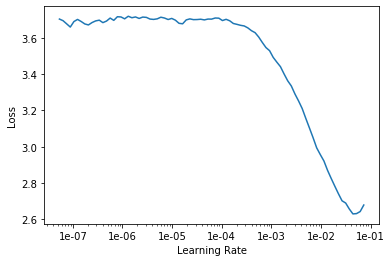

In [27]:
learner.lr_find(start_lr=1e-08,end_lr=0.2, num_it=100) 


Min numerical gradient: 6.93E-03
Min loss divided by 10: 4.40E-03


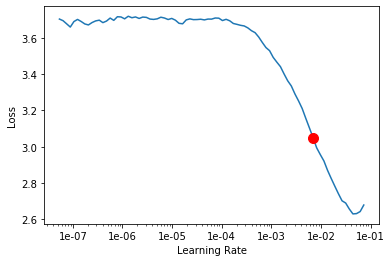

In [28]:
learner.recorder.plot(suggestion=True)

In [29]:
mingradlr = learner.recorder.min_grad_lr
print(mingradlr)

0.00693144843155147


### Training the leraner

In [30]:
lr = mingradlr
learner.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.627578,3.152290,0.929293,0.070707,00:11
1,3.099198,3.434292,0.898990,0.101010,00:09
2,2.528100,4.493905,0.929293,0.070707,00:09
3,2.120866,4.234680,0.868687,0.131313,00:10
4,1.826999,4.693913,0.878788,0.121212,00:08
5,1.557921,4.426708,0.888889,0.111111,00:12
6,1.347751,4.479911,0.888889,0.111111,00:11
7,1.171403,4.438340,0.848485,0.151515,00:10
8,1.015877,4.327882,0.838384,0.161616,00:09
9,0.902170,4.267944,0.838384,0.161616,00:08


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-08
Min loss divided by 10: 3.64E-05


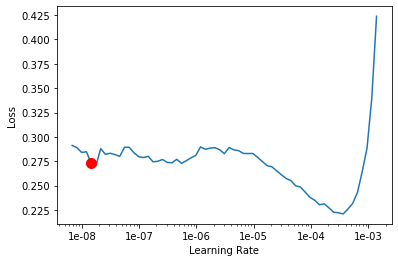

In [32]:
learner.unfreeze()
learner.lr_find(start_lr=1e-09,end_lr=0.2, num_it=100) 
learner.recorder.plot(suggestion=True)

In [33]:
mingradlr1 = learner.recorder.min_grad_lr
print(mingradlr1)

1.4525938442541211e-08


### Differential learning 

In [34]:
learner.fit_one_cycle(7, slice(mingradlr1, mingradlr1/20))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.264360,4.244513,0.848485,0.151515,00:10
1,0.252949,4.253255,0.848485,0.151515,00:10
2,0.256714,4.234333,0.848485,0.151515,00:10
3,0.271570,4.219579,0.848485,0.151515,00:09
4,0.263202,4.237198,0.858586,0.141414,00:09
5,0.268455,4.227379,0.848485,0.151515,00:08
6,0.268061,4.222262,0.848485,0.151515,00:09


### Results

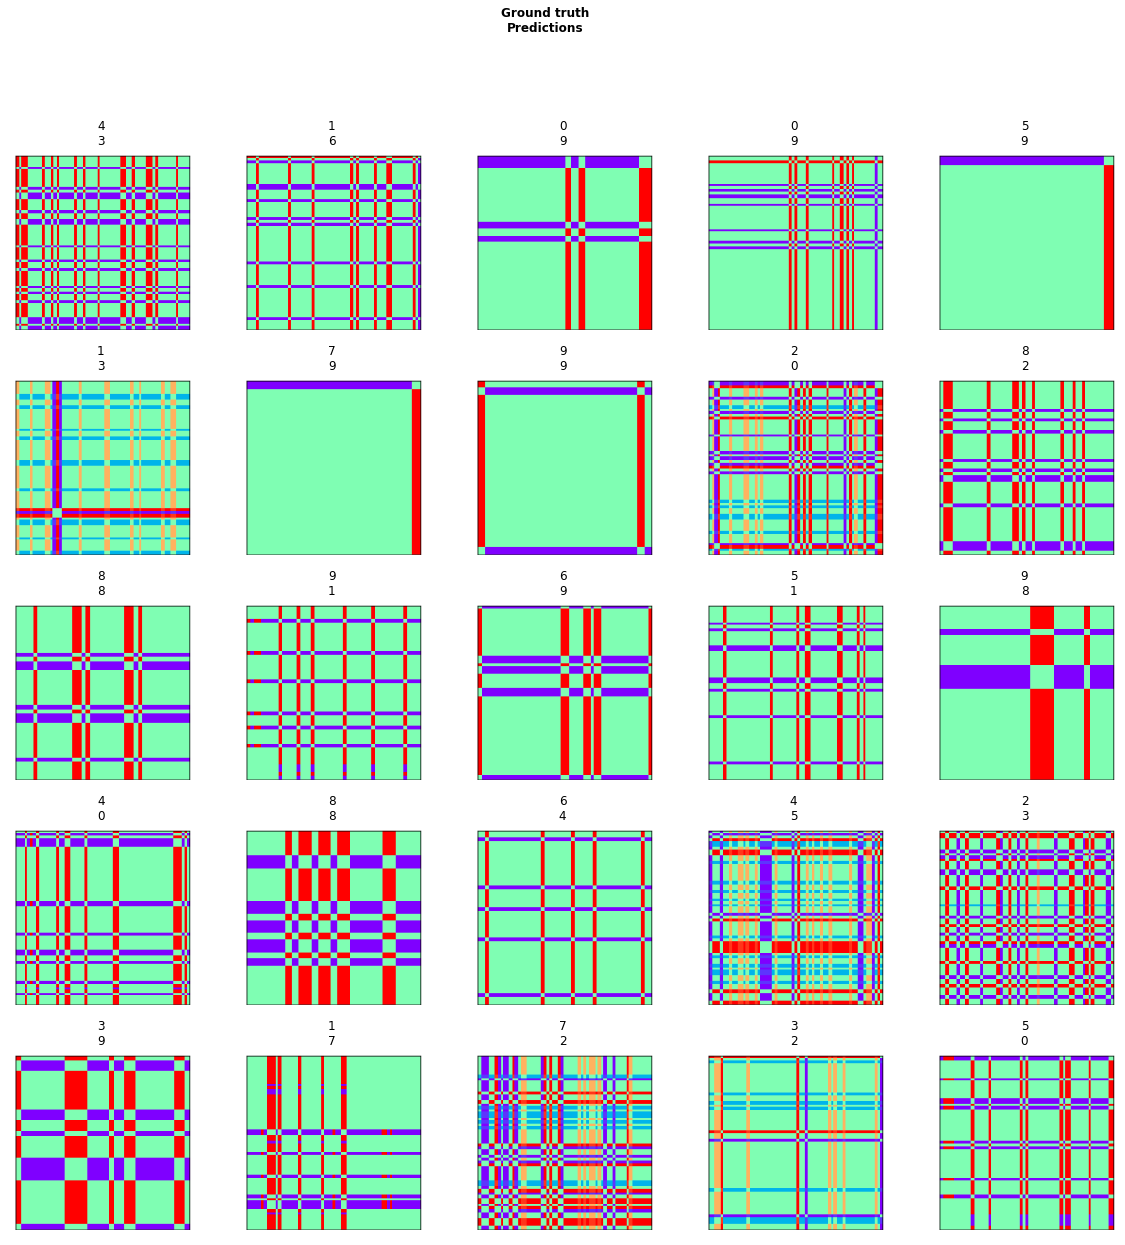

In [35]:
learner.show_results()

### Save Model

In [44]:
# path = '../models'
# learner.save('current_best_.h5')
# assert (path+'/tmp.pth').exists()

AttributeError: 'str' object has no attribute 'exists'